#**Case: Single-Slide Preprocessing**

In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (180 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls '/content/drive/My Drive/ADL Project'

Images


In [5]:
!ls '/content/drive/My Drive/ADL Project/Images'

tumor_001_mask.tif  tumor_019.xml	tumor_059.xml	    tumor_091.tif
tumor_001.tif	    tumor_023_mask.tif	tumor_064_mask.tif  tumor_091.xml
tumor_001.xml	    tumor_023.tif	tumor_064.tif	    tumor_094_mask.tif
tumor_002_mask.tif  tumor_023.xml	tumor_064.xml	    tumor_094.tif
tumor_002.tif	    tumor_031_mask.tif	tumor_075_mask.tif  tumor_094.xml
tumor_002.xml	    tumor_031.tif	tumor_075.tif	    tumor_096_mask.tif
tumor_005_mask.tif  tumor_031.xml	tumor_075.xml	    tumor_096.tif
tumor_005.tif	    tumor_035_mask.tif	tumor_078_mask.tif  tumor_096.xml
tumor_005.xml	    tumor_035.tif	tumor_078.tif	    tumor_101_mask.tif
tumor_012_mask.tif  tumor_035.xml	tumor_078.xml	    tumor_101.tif
tumor_012.tif	    tumor_038.tif	tumor_081_mask.tif  tumor_101.xml
tumor_012.xml	    tumor_038.xml	tumor_081.tif	    tumor_110_mask.tif
tumor_016_mask.tif  tumor_057_mask.tif	tumor_081.xml	    tumor_110.tif
tumor_016.tif	    tumor_057.tif	tumor_084_mask.tif  tumor_110.xml
tumor_016.xml	    tumor_057.xml	tumor_084.ti

##**1. Starter Code Functions**




In [6]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [7]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

In [8]:
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [9]:
def read_tile(tile, as_float=False):
    im = tile
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    return im

In [10]:
def get_maching_level(tiles, slide, lv):
  nlv = 0
  for i, dim in enumerate(tiles.level_dimensions):
    if slide.level_dimensions[lv] == dim:
      nlv = i
  return nlv

In [11]:
def resize_tile(tile_sz, region_unequal, region_mask_unequal):
  region_r = region_unequal.resize((tile_sz, tile_sz))
  region_mask_r = region_mask_unequal.resize((tile_sz, tile_sz))
  return  region_r, region_mask_r

##**2. Upload Images**

In [12]:
#Slides_all=['001', '002', '005', '012', '016', '019', '023', '031', '038', '035', '057', '059', '064', '075', '078', '081', '084', '091', '094', '096', '101', '110']
#Slides_train = ['001', '002', '005', '012', '016', '019', '023', '031','035', '057', '059', '064', '075', '078', '081', '084', '091']
#Slides_test = ['038', '094', '096', '101', '110']

In [13]:
Slides_train = ['091']
Slides_test = ['110']

In [14]:
path_dir_images = os.getcwd() + '/drive/My Drive/ADL Project/Images'

slide_path = path_dir_images +'/' +'tumor_' + Slides_train[0] +'.tif'
tumor_mask_path = path_dir_images +'/' +'tumor_' + Slides_train[0] +'_mask.tif'

In [15]:
##Choose parametres for level and tile size
lv = 4

tile_sz = 256

In [16]:
slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

In [17]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=lv, 
                         width=slide.level_dimensions[lv][0], 
                         height=slide.level_dimensions[lv][1])

mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=lv, 
                        width=slide.level_dimensions[lv][0], 
                        height=slide.level_dimensions[lv][1])
mask_image = mask_image[:,:,0]

In [18]:
print("Slide includes %d levels", min(len(slide.level_dimensions), len(tumor_mask.level_dimensions)))
for i in range(min(len(slide.level_dimensions), len(tumor_mask.level_dimensions))):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[lv]
assert width * slide.level_downsamples[lv] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[lv] == slide.level_dimensions[0][1]

Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


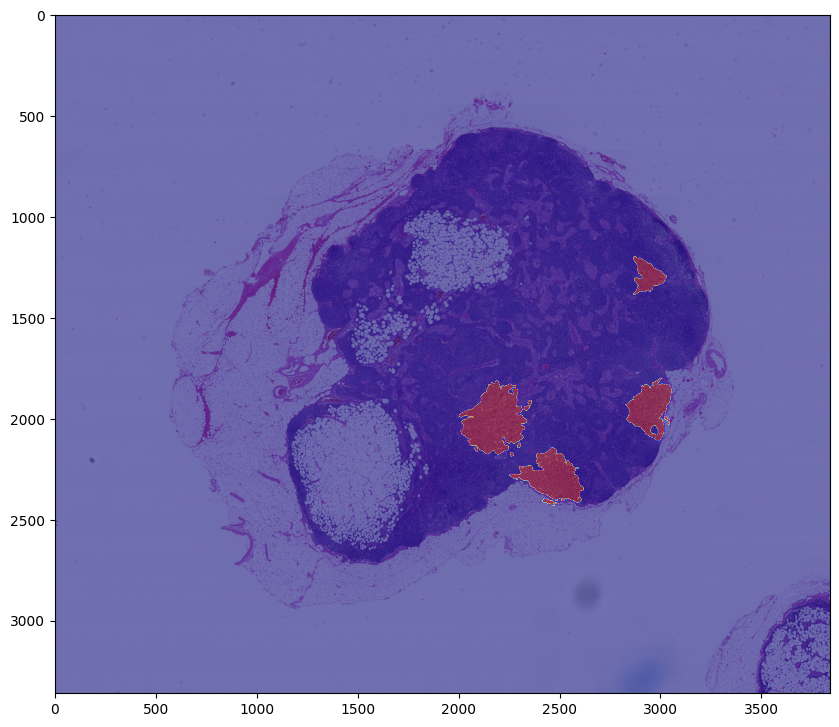

In [19]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5)

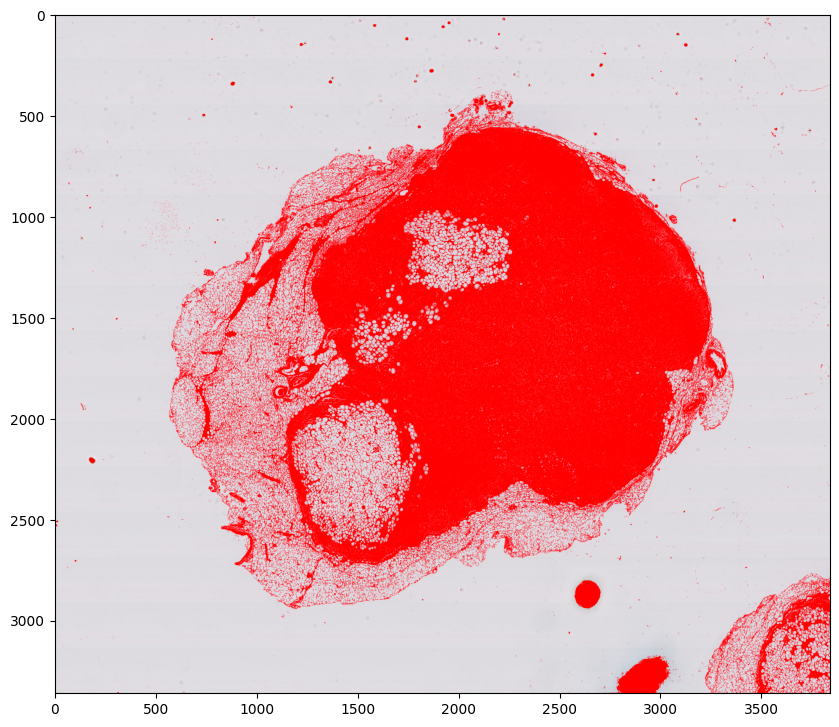

In [20]:
tissue_pixels_s = find_tissue_pixels(slide_image)
tissue_regions_s = apply_mask(slide_image, tissue_pixels_s)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(tissue_regions_s)

##**3. Generating Patches and labels - Zoom Level 4**

In [21]:
## Use DeepZoomGenerator to create the tile of the image
from openslide.deepzoom import DeepZoomGenerator 

In [22]:
tiles = DeepZoomGenerator(slide, tile_size=tile_sz, overlap=0, limit_bounds=True)
tiles_mask = DeepZoomGenerator(tumor_mask, tile_size=tile_sz, overlap=0, limit_bounds=True)

In [23]:
for i in range(len(tiles.level_dimensions)):
    print("Level %d, dimensions: %s" % (i,tiles.level_dimensions[i]))

Level 0, dimensions: (1, 1)
Level 1, dimensions: (2, 2)
Level 2, dimensions: (4, 4)
Level 3, dimensions: (8, 7)
Level 4, dimensions: (15, 14)
Level 5, dimensions: (30, 27)
Level 6, dimensions: (60, 53)
Level 7, dimensions: (120, 105)
Level 8, dimensions: (240, 210)
Level 9, dimensions: (480, 420)
Level 10, dimensions: (960, 840)
Level 11, dimensions: (1920, 1680)
Level 12, dimensions: (3840, 3360)
Level 13, dimensions: (7680, 6720)
Level 14, dimensions: (15360, 13440)
Level 15, dimensions: (30720, 26880)
Level 16, dimensions: (61440, 53760)


In [24]:
#Get the maching level dimension between the slide and the tile
nlv = get_maching_level(tiles, slide, lv)
nlv

12

In [25]:
#Get the dimension of the Grid of tiles
tiles.level_tiles[nlv]

(15, 14)

In [26]:
## Generate and review the size of the tiles
plots_im = []
plots_mask = []

for i in range(tiles.level_tiles[nlv][1]):
  for j in range(tiles.level_tiles[nlv][0]):

    region = tiles.get_tile(nlv, (j,i))
    region_mask = tiles_mask.get_tile(nlv, (j,i))

    tile = read_tile(region)
    tile_mask = read_tile(region_mask)[:,:,0]

    if i< tiles.level_tiles[nlv][1] and j ==0:
      print("tile: (%d,%d), tile_shape: %s,  mask_shape: %s " %(j,i ,tile.shape, tile_mask.shape ))

    plots_im.append(tile)
    plots_mask.append(tile_mask)

tile: (0,0), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,1), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,2), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,3), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,4), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,5), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,6), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,7), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,8), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,9), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,10), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,11), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,12), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,13), tile_shape: (32, 256, 3),  mask_shape: (32, 256) 


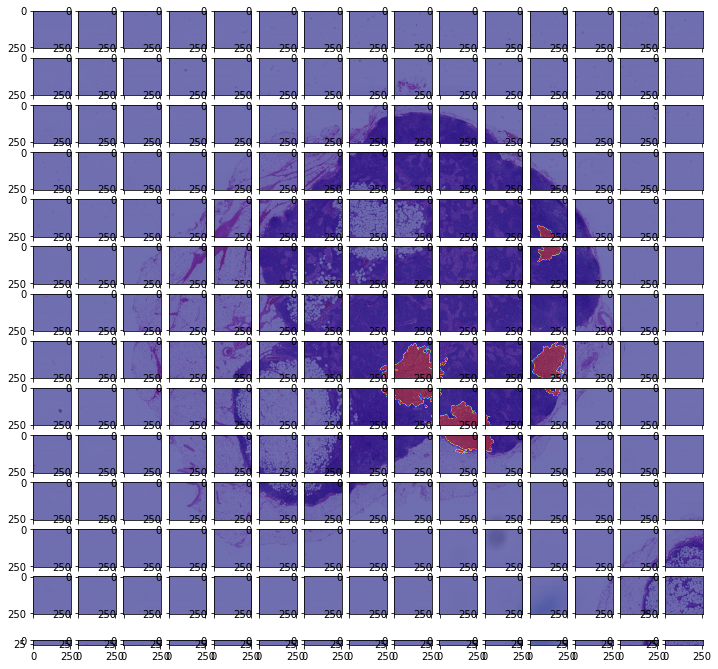

In [27]:
fig, axes = plt.subplots(tiles.level_tiles[nlv][1], tiles.level_tiles[nlv][0], figsize=(12, 12), sharex = True)

for i, ax in enumerate(axes.ravel()):
    if i > tiles.level_tiles[nlv][0] * tiles.level_tiles[nlv][1]:
        ax.set_visible(False)
        continue
    ax.imshow(plots_im[i])
    ax.imshow(plots_mask[i], cmap='jet', alpha=0.5)

In [28]:
## Generate and review the size of the tiles
plots_im = []
plots_mask = []

for i in range(tiles.level_tiles[nlv][1]):
  for j in range(tiles.level_tiles[nlv][0]):

    region = tiles.get_tile(nlv, (j,i))
    region_mask = tiles_mask.get_tile(nlv, (j,i))

    if region != (tile_sz, tile_sz) or region_mask != (tile_sz, tile_sz):
      region, region_mask  = resize_tile(tile_sz, region, region_mask)
    else:
      region = region
      region_mask = region_mask

    tile = read_tile(region)
    tile_mask = read_tile(region_mask)[:,:,0]

    if i< tiles.level_tiles[nlv][1] and j ==0:
      print("tile: (%d,%d), tile_shape: %s,  mask_shape: %s " %(j,i ,tile.shape, tile_mask.shape ))

    plots_im.append(tile)
    plots_mask.append(tile_mask)

tile: (0,0), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,1), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,2), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,3), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,4), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,5), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,6), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,7), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,8), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,9), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,10), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,11), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,12), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 
tile: (0,13), tile_shape: (256, 256, 3),  mask_shape: (256, 256) 


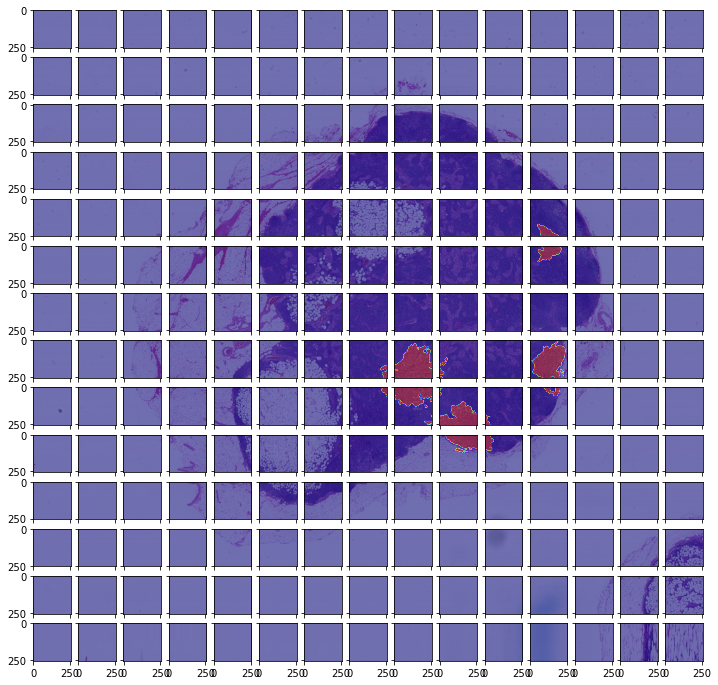

In [29]:
fig, axes = plt.subplots(tiles.level_tiles[nlv][1], tiles.level_tiles[nlv][0], figsize=(12, 12), sharex=True, sharey=True)

for i, ax in enumerate(axes.ravel()):
    if i > tiles.level_tiles[nlv][0] * tiles.level_tiles[nlv][1]:
        ax.set_visible(False)
        continue
    ax.imshow(plots_im[i])
    ax.imshow(plots_mask[i], cmap='jet', alpha=0.5)

In [32]:
#Explore a specific region in the grid of tiles that were created by the DeepZoomGenerator
region = tiles.get_tile(nlv, (11, 4)) #(4,4) image 091 (7,16) image 005 (0,26) image 005 
region_mask = tiles_mask.get_tile(nlv, (11,4))

In [33]:
tile_1 = read_tile(region)
tile_1_mask = read_tile(region_mask)[:,:,0]

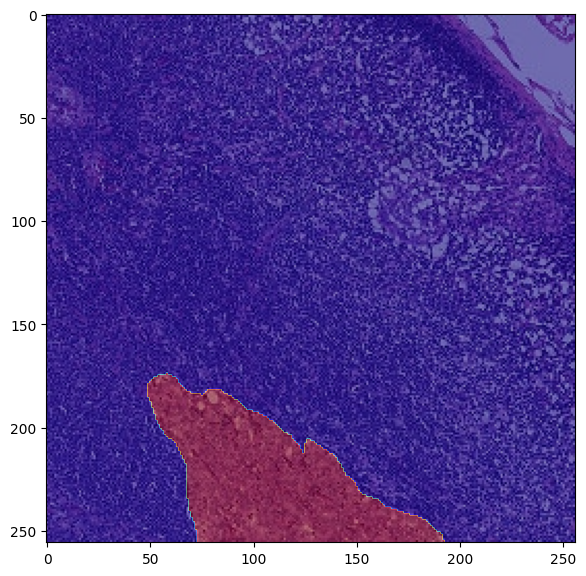

In [34]:
plt.figure(figsize=(7,7), dpi=100)
plt.imshow(tile_1)
plt.imshow(tile_1_mask, cmap='jet', alpha=0.5)

In [35]:
#Get the percentage of tissue in the tile
tissue_pixels = find_tissue_pixels(tile_1)
percent_tissue = len(tissue_pixels) / float(tile_1.shape[0] * tile_1.shape[1]) * 100
print ("%d tissue_pixels pixels (%.4f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

62371 tissue_pixels pixels (95.1706 percent of the image)


In [36]:
#Get the percentage of mask in the tile
mask_pixels = find_tissue_pixels(tile_1_mask)
percent_mask = 100 - len(mask_pixels) / float(tile_1_mask.shape[0] * tile_1_mask.shape[1]) * 100
print ("%d mask_pixels pixels (%.4f percent of the image)" % (len(mask_pixels), percent_mask)) 

59762 mask_pixels pixels (8.8104 percent of the image)


In [37]:
#Evaluate if the center of the tile has a tumor
ind_tumor = np.sum(tile_1_mask[int(tile_sz/4): int(tile_sz/4+tile_sz/2), int(tile_sz/4): int(tile_sz/4+tile_sz/2)])

if ind_tumor > 0:
  print('There is a tumor in the center of the tile')
else:
  print('There is no tumor in the center of the tile')

There is a tumor in the center of the tile
